In [1]:
import pandas as pd
import auxiliar_wedge

# Load data

In [2]:
input_path = 'treatments/'

MIMIC_treatment= input_path + 'MIMIC_cancer_treatments.csv'
MIMIC_treatment = pd.read_csv(MIMIC_treatment, delimiter=",")
MIMIC_drugBank_id = pd.read_csv(input_path + 'MIMIC_drugBank_id.csv', delimiter=",")

display(MIMIC_treatment.shape, MIMIC_treatment.head())
display(MIMIC_drugBank_id.shape, MIMIC_drugBank_id.head())

(239, 1)

,treatment
0,"Acyclovir, Allopurinol, Calcium_gluconate, Clo..."
1,"Acetaminophen, Acyclovir, Aluminum_hydroxide, ..."
2,"Acetaminophen, Aldesleukin, Calcium_gluconate,..."
3,"Acetaminophen, Allopurinol, Azithromycin, Dexa..."
4,"Acetaminophen, Allopurinol, Atenolol, Bisacody..."


(240, 2)

,DrugBankID,DrugName
0,DB00009,Alteplase
1,DB00016,Erythropoietin
2,DB00030,Insulin_human
3,DB00040,Glucagon
4,DB00041,Aldesleukin


# Load treatments from KG

In [2]:
input_path = 'treatments/'

#KG_treatment= input_path + 'cancer_treatments.csv'
#KG_treatment= input_path + 'BM_treatment_emergency.csv'
KG_treatment= input_path + 'BM_treatment_toxicity.csv'

KG_treatment = pd.read_csv(KG_treatment, delimiter=",")
KG_drugBank_id = pd.read_csv(input_path + 'KG_drugBank_id.csv', delimiter=",")

display(KG_treatment.shape, KG_treatment.head())
display(KG_drugBank_id.shape, KG_drugBank_id.head())

(138, 2)

,treatment,Toxicity
0,"Carboplatin, Docetaxel, Pemetrexed, Vinorelbin...",7.0
1,"Carboplatin, Docetaxel, Gemcitabine, Pemetrexe...",6.0
2,"Carboplatin, Etoposide, Vinorelbine, Atenolol,...",6.0
3,"Cisplatin, Docetaxel, Gemcitabine, Pemetrexed,...",6.0
4,"Carboplatin, Docetaxel, Pemetrexed, Omeprazole...",5.0


(54, 2)

,DrugBankID,DrugName
0,DB00028,Human_immunoglobulin_g
1,DB00112,Bevacizumab
2,DB00186,Lorazepam
3,DB00193,Tramadol
4,DB00207,Azithromycin


In [3]:
ddi = auxiliar_wedge.load_dataset_ddi('../../data/Clarify/v6.2/drug/Unsymmetric_DDI_corpus.csv')
display(ddi.shape, ddi.head())

(720429, 6)

,EffectorDrugLabel,AffectedDrugLabel,Effect,Impact,precipitantDrug,objectDrug
0,Etanercept,Caffeine,metabolism,increase,DB00005,DB00201
1,Etanercept,Fluvoxamine,metabolism,increase,DB00005,DB00176
2,Etanercept,Betaxolol,metabolism,increase,DB00005,DB00195
3,Etanercept,Carmustine,metabolism,increase,DB00005,DB00262
4,Etanercept,Ropinirole,metabolism,increase,DB00005,DB00268


In [4]:
def treatment_evaluation(df_treatment, drugBank_id, ddi, th):
    treatment_class = pd.DataFrame(columns=['treatments', 'Toxic', 'Lower Effect', 'Effective', 'Deductive-Toxic',
                      'Deductive-Lower Effect', 'Deductive-Effective'])

    for i in range(df_treatment.shape[0]):
        drugs = df_treatment.treatment[i]
        list_d = drugs.split(', ')
        input_data = drugBank_id.loc[drugBank_id.DrugName.isin(list_d)].DrugBankID.values
        union, comorbidity_drug, set_DDIs = auxiliar_wedge.load_ddi(ddi, input_data)
        g1, g2, g1_classified, g2_classified = auxiliar_wedge.capture_knowledge(union, comorbidity_drug, set_DDIs)
        max_ddi = len(list_d)*(len(list_d)-1) / 2
        
        if ('HigherToxicity' not in g2_classified.Class.value_counts().index) and (
            'LowerEffectiveness' not in g2_classified.Class.value_counts().index):
            treatment_class.at[i, 'treatments'] = drugs
            treatment_class.at[i, 'Deductive-Effective'] = 1
            treatment_class.at[i, 'Effective'] = 1
            continue
        tox_g2 = 0
        eff_g2 = 0
        tox_g1 = 0
        eff_g1 = 0
        if 'HigherToxicity' in g2_classified.Class.value_counts().index:
            tox_g2 = g2_classified.Class.value_counts().HigherToxicity / max_ddi
        if 'LowerEffectiveness' in g2_classified.Class.value_counts().index:
            eff_g2 = g2_classified.Class.value_counts().LowerEffectiveness / max_ddi
        if (tox_g2 < th) and (eff_g2 < th):
            treatment_class.at[i, 'treatments'] = drugs
            treatment_class.at[i, 'Deductive-Effective'] = 1
            treatment_class.at[i, 'Effective'] = 1
            continue
        if (tox_g2 >= th):
            treatment_class.at[i, 'treatments'] = drugs
            treatment_class.at[i, 'Deductive-Toxic'] = 1
        if (eff_g2 >= th):
            treatment_class.at[i, 'treatments'] = drugs
            treatment_class.at[i, 'Deductive-Lower Effect'] = 1

        if 'HigherToxicity' in g1_classified.Class.value_counts().index:
            tox_g1 = g1_classified.Class.value_counts().HigherToxicity / max_ddi
        if 'LowerEffectiveness' in g1_classified.Class.value_counts().index:
            eff_g1 = g1_classified.Class.value_counts().LowerEffectiveness / max_ddi
        if (tox_g1 < th) and (eff_g1 < th):
            treatment_class.at[i, 'treatments'] = drugs
            treatment_class.at[i, 'Effective'] = 1
            continue
        if (tox_g1 >= th):
            treatment_class.at[i, 'treatments'] = drugs
            treatment_class.at[i, 'Toxic'] = 1
        if (eff_g1 >= th):
            treatment_class.at[i, 'treatments'] = drugs
            treatment_class.at[i, 'Lower Effect'] = 1

    treatment_class = treatment_class.fillna(0)
    return treatment_class

In [6]:
treatment_class = treatment_evaluation(MIMIC_treatment, MIMIC_drugBank_id, ddi, th=0.6)
treatment_class.head()

,treatments,Toxic,Lower Effect,Effective,Deductive-Toxic,Deductive-Lower Effect,Deductive-Effective
0,"Acyclovir, Allopurinol, Calcium_gluconate, Clo...",0,0,1,1,0,0
1,"Acetaminophen, Acyclovir, Aluminum_hydroxide, ...",0,0,1,0,0,1
2,"Acetaminophen, Aldesleukin, Calcium_gluconate,...",0,0,1,1,0,0
3,"Acetaminophen, Allopurinol, Azithromycin, Dexa...",0,0,1,1,0,0
4,"Acetaminophen, Allopurinol, Atenolol, Bisacody...",0,0,1,0,0,1


In [5]:
treatment_class = treatment_evaluation(KG_treatment, KG_drugBank_id, ddi, th=0.6)
treatment_class.head()

,treatments,Toxic,Lower Effect,Effective,Deductive-Toxic,Deductive-Lower Effect,Deductive-Effective,Emergency
0,"Carboplatin, Paclitaxel, Atorvastatin, Levoflo...",0,0,1,0,0,1,12.0
1,"Carboplatin, Etoposide, Atorvastatin, Enalapri...",0,0,1,0,0,1,8.0
2,"Cisplatin, Pemetrexed, Vinorelbine, Lorazepam,...",0,0,1,1,0,0,7.0
3,"Carboplatin, Etoposide, Ibuprofen, Omeprazole,...",0,0,1,0,0,1,6.0
4,"Carboplatin, Pemetrexed, Dexamethasone, Loraze...",0,0,1,1,0,0,5.0


In [6]:
treatment_class['Deductive-Lower Effect'].value_counts()

0    134
1      4
Name: Deductive-Lower Effect, dtype: int64

In [13]:
treatment_class.loc[(treatment_class['Deductive-Lower Effect']==1) & (treatment_class['Deductive-Toxic']==1)]

,treatments,Toxic,Lower Effect,Effective,Deductive-Toxic,Deductive-Lower Effect,Deductive-Effective


In [12]:
treatment_class.loc[(treatment_class['Deductive-Lower Effect']==1)].treatments.values

array(['Cisplatin, Vinorelbine, Dexamethasone, Enoxaparin, Metoclopramide, Omeprazole',
       'Afatinib, Acetaminophen, Amlodipine, Lorazepam, Omeprazole'],
      dtype=object)

In [17]:
def treatment_evaluation(df_treatment, drugBank_id, ddi):
    #treatment_class = pd.DataFrame(columns=['treatments', 'Toxic', 'Lower Effect', 'Deductive-Toxic', 
    #                                        'Deductive-Lower Effect', 'Toxicity'])
    treatment_class = pd.DataFrame(columns=['treatments', 'Toxic', 'Deductive-Toxic', 'Toxicity'])

    for i in range(df_treatment.shape[0]):
        drugs = df_treatment.treatment[i]
        list_d = drugs.split(', ')
        input_data = drugBank_id.loc[drugBank_id.DrugName.isin(list_d)].DrugBankID.values
        union, comorbidity_drug, set_DDIs = auxiliar_wedge.load_ddi(ddi, input_data)
        g1, g2, g1_classified, g2_classified = auxiliar_wedge.capture_knowledge(union, comorbidity_drug, set_DDIs)
        max_ddi = len(g1_classified.Effect_Impact.unique()) * len(list_d)*(len(list_d)-1) / 2
        treatment_class.at[i, 'treatments'] = drugs
        """
        if 'HigherToxicity' in g1_classified.Class.value_counts().index:
            tox_g1 = g1_classified.Class.value_counts().HigherToxicity / max_ddi
            treatment_class.at[i, 'Toxic'] = tox_g1
        if 'LowerEffectiveness' in g1_classified.Class.value_counts().index:
            eff_g1 = g1_classified.Class.value_counts().LowerEffectiveness / max_ddi
            treatment_class.at[i, 'Lower Effect'] = eff_g1
        if 'HigherToxicity' in g2_classified.Class.value_counts().index:
            tox_g2 = g2_classified.Class.value_counts().HigherToxicity / max_ddi
            treatment_class.at[i, 'Deductive-Toxic'] = tox_g2
        if 'LowerEffectiveness' in g2_classified.Class.value_counts().index:
            eff_g2 = g2_classified.Class.value_counts().LowerEffectiveness / max_ddi
            treatment_class.at[i, 'Deductive-Lower Effect'] = eff_g2
        """
        treatment_class.at[i, 'Toxicity'] = df_treatment.Toxicity[i]
        
        treatment_class.at[i, 'Toxic'] = g1_classified.Class.value_counts().values.sum() / max_ddi
        treatment_class.at[i, 'Deductive-Toxic'] = g2_classified.Class.value_counts().values.sum() / max_ddi
        

    treatment_class = treatment_class.fillna(0)
    return treatment_class

treatment_class = treatment_evaluation(KG_treatment, KG_drugBank_id, ddi)
treatment_class#.head()

,treatments,Toxic,Deductive-Toxic,Toxicity
0,"Carboplatin, Docetaxel, Pemetrexed, Vinorelbin...",0.119048,0.369048,7.0
1,"Carboplatin, Docetaxel, Gemcitabine, Pemetrexe...",0.222222,0.311111,6.0
2,"Carboplatin, Etoposide, Vinorelbine, Atenolol,...",0.250000,0.250000,6.0
3,"Cisplatin, Docetaxel, Gemcitabine, Pemetrexed,...",0.100000,0.100000,6.0
4,"Carboplatin, Docetaxel, Pemetrexed, Omeprazole...",0.200000,0.200000,5.0
...,...,...,...,...
133,"Cisplatin, Pemetrexed, Vinorelbine, Lorazepam,...",0.183333,0.233333,0.0
134,"Carboplatin, Atorvastatin, Furosemide, Metform...",0.166667,0.233333,0.0
135,"Cisplatin, Acetaminophen, Atenolol, Fentanyl, ...",0.250000,0.616667,0.0
136,"Pemetrexed, Amoxicillin, Atenolol, Ceftriaxone...",0.133333,0.133333,0.0


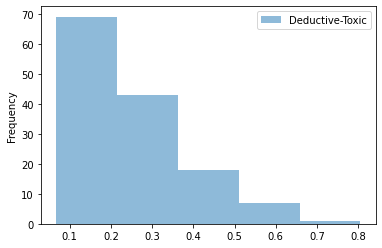

In [20]:
df = treatment_class[['Deductive-Toxic']]
ax = df.plot.hist(bins=5, alpha=0.5)

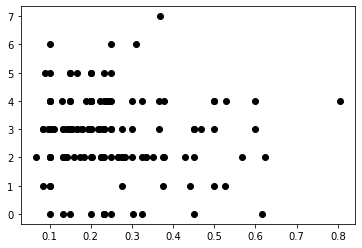

In [21]:
import matplotlib.pyplot as plt
# Plot outputs
plt.scatter(treatment_class[['Deductive-Toxic']], treatment_class[['Toxicity']], color="black")

In [9]:
treatment_class

,treatments,Toxic,Lower Effect,Deductive-Toxic,Deductive-Lower Effect,Emergency
0,"Carboplatin, Paclitaxel, Atorvastatin, Levoflo...",0.400000,0.100000,0.500000,0.100000,12.0
1,"Carboplatin, Etoposide, Atorvastatin, Enalapri...",0.266667,0.066667,0.266667,0.066667,8.0
2,"Cisplatin, Pemetrexed, Vinorelbine, Lorazepam,...",0.533333,0.200000,0.733333,0.200000,7.0
3,"Carboplatin, Etoposide, Ibuprofen, Omeprazole,...",0.300000,0.100000,0.300000,0.100000,6.0
4,"Carboplatin, Pemetrexed, Dexamethasone, Loraze...",0.400000,0.400000,0.600000,0.500000,5.0
...,...,...,...,...,...,...
133,"Carboplatin, Paclitaxel, Dexamethasone, Fentan...",0.533333,0.333333,0.733333,0.333333,0.0
134,"Cisplatin, Paclitaxel, Atorvastatin, Enalapril...",0.266667,0.066667,0.666667,0.066667,0.0
135,"Carboplatin, Etoposide, Atenolol, Atorvastatin...",0.500000,0.100000,0.700000,0.100000,0.0
136,"Carboplatin, Pemetrexed, Allopurinol, Amlodipi...",0.466667,0.000000,0.733333,0.000000,0.0


In [10]:
treatment_class.to_csv('treatments/treatment_class.csv', index=False)
